In [1]:
!pip install git+https://github.com/tensorflow/examples.git

import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-oqi3sxo7
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-oqi3sxo7
  Resolved https://github.com/tensorflow/examples.git to commit a71f7e38b0ce56e9f39d8049e836ea8f7af74f83
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a71f7e38b0ce56e9f39d8049e836ea8f7af74f83_-py3-none-any.whl size=299718 sha256=5f403360bc69b406fbf6f22cc6ae107dbe145768d800c5df62d80fce8fde15dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ho7ah0_/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel c

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
import tensorflow_datasets as С
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
dataset, info = tfds.load('caltech_birds2010:0.*.*', with_info=True)

Dataset caltech_birds2010 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.


In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

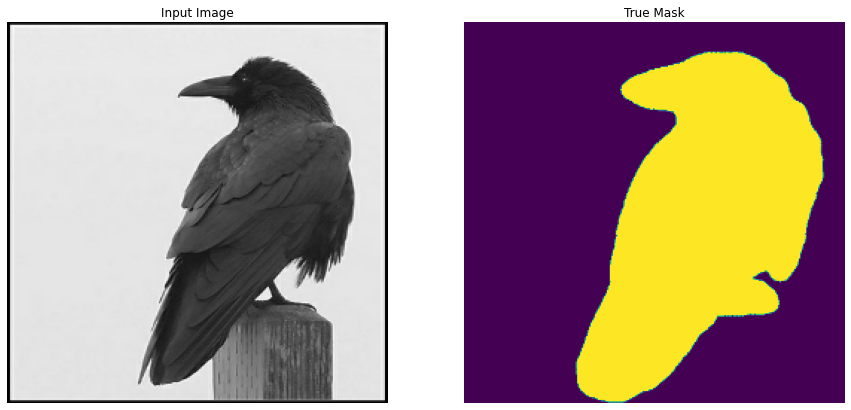

In [11]:
for image, mask in train.take(12):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [12]:
OUTPUT_CHANNELS = 3

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [15]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='SGD',
              loss=tf.keras.losses.KLDivergence(),
              metrics=['top_k_categorical_accuracy'])

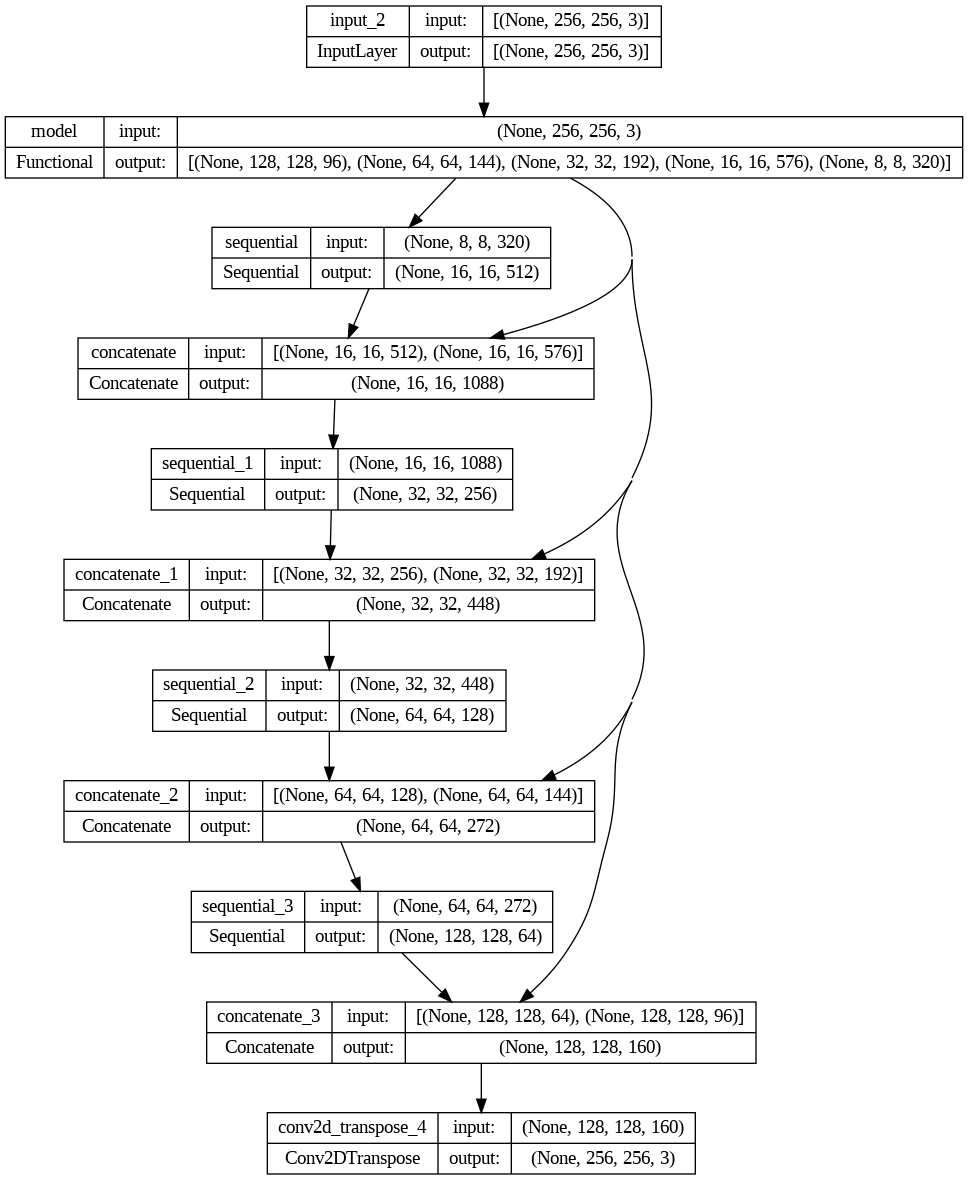

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


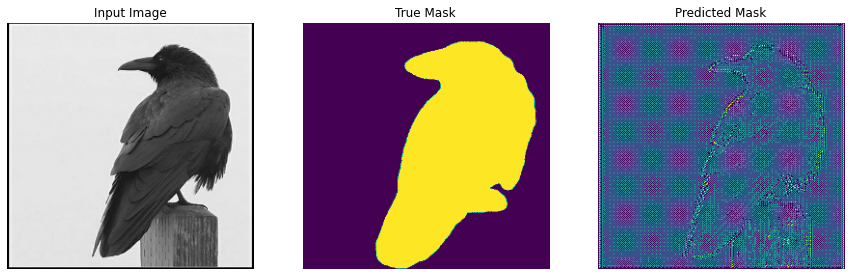

In [20]:
show_predictions()

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 130ms/step


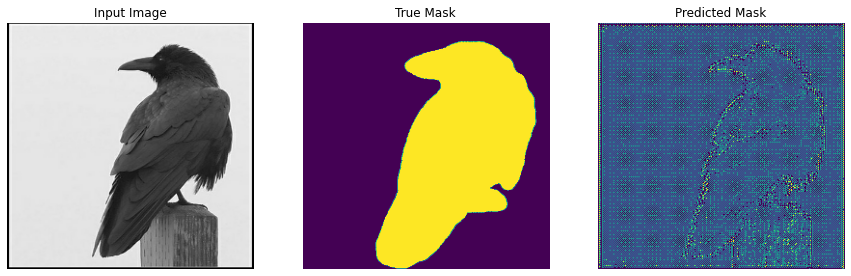


Sample Prediction after epoch 10

93/93 [==============================] - 847s 9s/step - loss: -2.1424e-06 - top_k_categorical_accuracy: 1.0000 - val_loss: -2.1424e-06 - val_top_k_categorical_accuracy: 1.0000


In [23]:
EPOCHS = 10 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

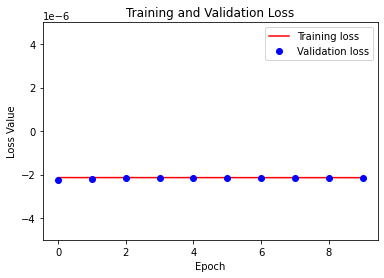

In [51]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([-0.000005, 0.000005])
plt.legend()
plt.show()

1/1 [==============================] - 5s 5s/step


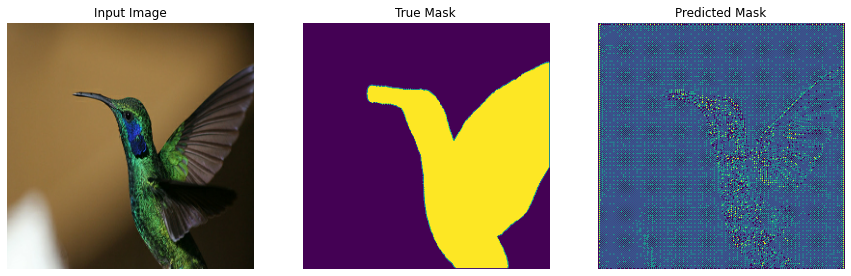

1/1 [==============================] - 3s 3s/step


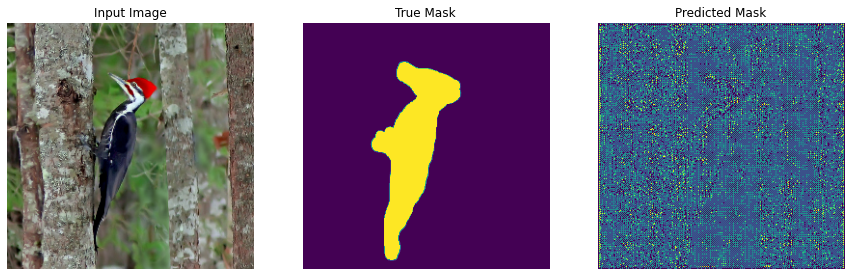

1/1 [==============================] - 4s 4s/step


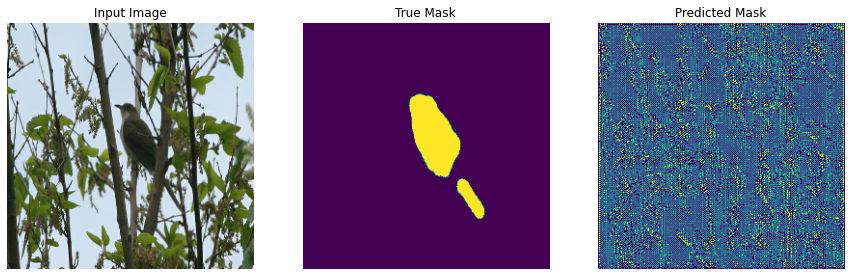

In [58]:
show_predictions(test_dataset, 3)

Как видно из полученных предсказаний, модель довольно неплохо, при обучении на 10-ти эпохах, произвела сегментацию изображений птиц.